In [ ]:
#################### СБОР ДАННЫХ ИЗ ВК

# Часть 1 - скачать пользователей с постами
# 1) Получить список id пользователей для обработки. Сохранить в файл. 
# 3) Получить информацию о городах и родных городах пользователей. Сохранить тех, у кого они различаются и у кого нет
# 3) Получить те города, которые упоминаются у наших пользователей
# 4) Получить места работы и учебы?

# Часть 2 - определять настроение

# Часть 3 - определить точки переезда

# Часть 4 - сравнить настроение на разных участках

######################### АНАЛИЗ ТОНАЛЬНОСТИ ПОСТОВ

# Часть 1 - классификация с помощью сети

# Часть 2 - классификация с помощью регрессии

# Часть 3 - классификация с помощью словаря

######################## АНАЛИЗ РАЗЛИЧИЙ

In [5]:
import vk
import time
import re
import csv
import math
# import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.tokenize import word_tokenize

%matplotlib inline
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [9]:
#open vk session
with open('token') as f:
    TOKEN = f.read()
session = vk.Session(access_token=TOKEN)
vkapi = vk.API(session)

In [10]:
#constants
SELF_ID = 7110301
SLEEP_TIME = 0.3

In [11]:
#get users list from file or from Vk
try:
    with open('01 - users.txt') as f:
        users = f.read().splitlines()
except FileNotFoundError:
    users = vkapi('friends.get')
    users2 = []
    for user in tqdm(users):
        try:
            users2 += vkapi('friends.get', user_id = user)
            time.sleep(SLEEP_TIME)
        except:
            continue
        if len(users2) > 5000: #will get ~370000 users without break
            break
    users += users2
    users = set(users)
    with open('01 - users.txt', 'w') as f:
        for user in users:
            f.write(str(user) + '\n')

users = [7110301,16498689, 7479298, 139411465, 475146, 19914761, 183230474, 5324819, 
         1581076, 17227799, 5111832, 5808166]

l = len(users)
print(l, 'users')
print('approx', l*1300, 'posts')
print('approx', round(l*10/60, 1),'minutes (', round(l*10/60/60, 2), 'hours ) to collect')

12 users
approx 15600 posts
approx 2.0 minutes ( 0.03 hours ) to collect


In [20]:
#get users info
try:
    user_info = pd.read_csv('02 - user_info.csv')
except FileNotFoundError:
    with open('02 - user_info.csv', 'w', encoding='utf-8', newline='') as csvfile: 
        fieldnames = ['uid', 'first_name', 'last_name', 'sex', 'city', 'home_town']
        writer = csv.DictWriter(
            csvfile, 
            fieldnames=fieldnames, 
            restval='NA', 
            extrasaction='ignore')
        writer.writeheader()
        for user in tqdm(users):
            try:
                uinfo = vkapi('users.get', user_id = user, fields = ['sex', 'city', 'home_town'])
                time.sleep(SLEEP_TIME)
                for u in uinfo:
                    writer.writerow(u)
            except:
                continue
    user_info = pd.read_csv('02 - user_info.csv')

In [21]:
#get cities list
try:
    cids = pd.read_csv('03 - cities.csv')
except FileNotFoundError:
    cities = []
    for c in tqdm(user_cities):
        city = vkapi('database.getCitiesById', city_ids=c)
        time.sleep(SLEEP_TIME)
        cities+=city
    with open('03 - cities.csv', 'w', encoding='utf-8', newline='') as csvfile: 
        fieldnames = ['cid', 'name']
        writer = csv.DictWriter(
            csvfile, 
            fieldnames=fieldnames, 
            restval='NA', 
            extrasaction='ignore')
        writer.writeheader()
        for c in cities:
            writer.writerow(c)
    cids = pd.read_csv('03 - cities.csv')
        
cids

,cid,name
0,1,Москва
1,2,Санкт-Петербург
2,103,Обнинск


In [ ]:
#add city names to usinfo
# for user in usinfo:

In [22]:
#get posts
def get_post_count(friend):
    posts = vkapi('wall.get', owner_id=friend, count=1, filter='owner')
    post_count = posts[0]
    return post_count

try:
    raw_posts = pd.read_csv('04 - raw_posts.csv')
except FileNotFoundError:
    with open('04 - raw_posts.csv', 'w', encoding='utf-8', newline='') as csvfile:
        fieldnames = ['to_id', 'from_id', 'post_type', 'date', 'text', 'copy_text']
        writer = csv.DictWriter(
            csvfile, 
            fieldnames=fieldnames, 
            restval='NA', 
            extrasaction='ignore')
        writer.writeheader()
        for user in tqdm(users, desc='Downloading posts'):
            current_post_count = get_post_count(user)
            time.sleep(SLEEP_TIME)
            if (current_post_count > 7000) or (current_post_count < 100):
                continue
            current_posts = []
            resid = current_post_count
            offset = 0
            while resid > 0:
                response = vkapi('wall.get', 
                    owner_id=user, 
                    count=100, 
                    filter='owner',
                    offset=offset)
                time.sleep(SLEEP_TIME)
                current_posts += response
                resid -= 100
                offset += 100
            for p in current_posts:
                if type(p) == dict:
                    writer.writerow(p)
    raw_posts = pd.read_csv('04 - raw_posts.csv')
    
raw_posts.head()

,to_id,from_id,post_type,date,text,copy_text
0,7110301,7110301,post,1493320920,"Ох, ох, очень нужны испытуемые! <br><br>Большо...",NaN
1,7110301,7110301,post,1508983492,Дурацкая квадратная луна,NaN
2,7110301,7110301,post,1508525760,"Очень не вовремя я заболел. Сентябрь, всё инте...",NaN
3,7110301,7110301,copy,1508330774,"Кем я стал, когда вырос?",NaN
4,7110301,7110301,copy,1507680635,"Я никогда особо не понимал, что происходит",NaN


### Удаляем пустые

In [23]:
def check_not_nan(x):
    if type(x) != float:
        return True
    else:
        return not math.isnan(x)

In [24]:
# posts = posts[posts.text.apply(check_not_nan) | posts.copy_text.apply(check_not_nan)]
raw_posts2 = raw_posts[raw_posts.text.apply(check_not_nan) | raw_posts.copy_text.apply(check_not_nan)]
raw_posts2.shape

(6297, 6)

### Очищаем текст постов и соединяем тексты (репост и авторский текст)

Текст копии и авторская приписка к тексту идут отдельными колонками. В первом приближении я просто соединяю их, исходя их того представления, что и авторский текст, и репост, и приписка к репосту могут передавать настроение. 

In [26]:
def cleanse(s): # ugly old version, update at convenience 
    rgxp = '[\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}0-9A-Za-z\-]' #del all except ) and (
    rgxp = '[\)\(\|©~^<>/\'\"\«№#$&\*.,;=+?!\—_@:\]\[%\{\}0-9A-Za-z\-]' #dell all
#     rgxp = '[©]' #del nothing
    return s.str.replace(rgxp, ' ').str.replace('\\n',' ').str.replace(' +', ' ')

In [27]:
posts_cl = pd.concat([raw_posts2.to_id,
                   raw_posts2.from_id,raw_posts2.date,
                   cleanse((raw_posts2.text.map(str) + raw_posts2.copy_text.map(str))
                           .str.replace('nan','')).rename('post')], 
                  axis = 1)
posts_cl.shape

(6297, 4)

### Длина постов

In [28]:
lens = np.array([len(t) for t in posts_cl.post])
print('Mean:', lens.mean(),
      '\nMedian:', np.median(lens), '\nMin:', min(lens), '\nMax:', max(lens))

Mean: 282.67444815 
Median: 61.0 
Min: 1 
Max: 15615


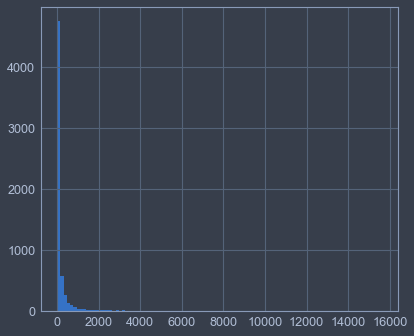

In [29]:
plt.hist(lens, bins=100);

In [30]:
trsh_up = 700
print('{:.2f}% постов короче {} б.'.format(lens[lens<trsh_up].shape[0]/lens.shape[0]*100, trsh_up))

91.76% постов короче 700 б.


In [31]:
trsh_lo = 15
print('{:.2f}% постов длиннее {} б.'.format(lens[lens>trsh_lo].shape[0]/lens.shape[0]*100, trsh_lo))

82.59% постов длиннее 15 б.


#### Выкинуть слишком короткие и длинные 

In [32]:
posts = posts_cl[(lens < trsh_up) & (lens > trsh_lo)]
posts.shape

(4682, 4)

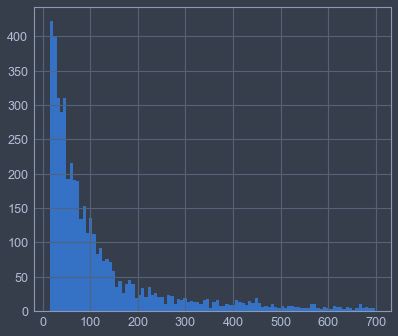

In [33]:
lens_ = np.array([len(t) for t in posts.post])
plt.hist(lens_, bins=100);

In [34]:
posts.to_csv('05 - posts.csv', encoding='utf=8')

In [30]:
import numpy as np
import pandas as pd

import pymorphy2
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline


In [31]:
#load training corpus (tweets)
fields = ['id', 'date', 'name', 'text', 'type', 'rep', 'trtw',
          'fav', 'stcount', 'fol', 'frien', 'listcount']

# – id: уникальный номер сообщения в системе twitter;
# – tdate: дата публикации сообщения (твита);
# – tmane: имя пользователя, опубликовавшего сообщение;
# – ttext:  текст сообщения (твита);
# – ttype:  к какому классу относится твит (положительный, отрицательный, нейтральный);
# – trep: количество реплаев к данному сообщению. Теперь API твиттера не отдает эту информацию;
# - trtw: ретвиты
# – tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
# – tstcount: число всех сообщений пользователя в сети twitter;
# – tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
# – tfrien: количество друзей пользователя (те люди, которых читает пользователь);
# – listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

neg = pd.read_csv('negative.csv', sep=';', header=None, names=fields)
pos = pd.read_csv('positive.csv', sep=';', header=None, names=fields)

data = pos.append(neg, ignore_index=True)

In [32]:
texts = cleanse(data['text'])
types = data['type']

texts_train, texts_test, types_train, types_test = train_test_split(texts, types, test_size=0.2)
texts[:10]

0     хоть я и школота но поверь у нас то же самое ...
1    Да все таки он немного похож на него Но мой ма...
2                  Ну ты идиотка я испугалась за тебя 
3     Кто то в углу сидит и погибает от голода а мы...
4     Вот что значит страшилка Но блин посмотрев вс...
5              ну любишь или нет Я не знаю кто ты бля 
6     Ох ну это конечно же Чтобы у нее было много д...
7       У тебя есть ухажёр Нет мои уши не кто не жрёт 
8                Поприветствуем моего нового читателя 
9                  Теперь у меня есть частичка Сиднея 
Name: text, dtype: object

In [33]:
# load control sample (vk posts)
control1 = pd.read_csv('control1.csv', sep=';')
control_texts = cleanse(control1.text)    
control_types = control1.type

In [34]:
def lemmatize(series):
    morph = pymorphy2.MorphAnalyzer()
    texts_n = [[morph.parse(i)[0].normal_form for i in word_tokenize(w)] for w in series]
    return [' '.join(t) for t in texts_n]

In [35]:
%%time
print(pd.Series(lemmatize(texts[:100])).shape)

(100,)
Wall time: 1.22 s


# Обучение модели и предсказание настроения

## Тестирование разных классификаторов

### Векторизация твитов

In [36]:
%%time
# vectorize tweets
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report

vectorizer = TfidfVectorizer(ngram_range=(1, 1), 
                             analyzer='word', 
                             tokenizer=word_tokenize, 
                             min_df = 100, 
                             max_df = 0.7, 
                             max_features = 3000)
#best res = 0,74 with Bayes and SVC 0,77 with RF on uncleaned data

vectorizer = TfidfVectorizer(ngram_range=(1, 3), 
                             analyzer='word', 
                             tokenizer=word_tokenize, 
                             min_df = 100, 
                             max_df = 0.51, 
                             max_features = 3000)
#best res = 0,65 with LG 0.67 SVC on cleaned data
# 0.67 with LG and SVC and RF on fully cleaned data

vectorizer = TfidfVectorizer(ngram_range=(3, 6), 
                             analyzer='char', 
                             tokenizer=word_tokenize, 
                             min_df = 100, 
                             max_df = 0.7, 
                             max_features = 5000)
#best res 0,77 with Bayes 0.78 with rf on uncleaned data
# 0.74 on cleaned data with RF

# note that the first time we call fit_transform, then we call simple transform. 
train_vec = vectorizer.fit_transform(texts_train)
test_vec = vectorizer.transform(texts_test)
control_vec = vectorizer.transform(control_texts)

Wall time: 1min 56s


In [37]:
train_vec.shape

(181467, 5000)

In [39]:
np.array(vectorizer.get_feature_names()
)[np.random.randint(0, len(vectorizer.get_feature_names()), 20)]

array(['е см', 'челове', ' напи', 'меня ', 'ы и', ' на к', 'зать', 'ини',
       ' круто', 'дст', ' кур', 'ура', 'к и ', 'ора ', ' ум', ' дом',
       'олг', 'пад', 'огл', ' в г'],
      dtype='<U6')

In [40]:
print(len(vectorizer.stop_words_))
np.array(list(vectorizer.stop_words_))[np.random.randint(0, len(vectorizer.stop_words_), 50)]

1825726


array(['сы – ', 'хаъпха', 'рприиз', 'ти дое', 'могиле', 'лизму', 'ыоо за',
       'рус о', 'покуд', 'щив', 'идужа', 'за фио', 'вил хо', ' века ',
       'тив ч', 'опе ми', 'уйка к', 'етеорт', 'визгам', 'еянск', 'еть п',
       'хо л', 'де ав', 'егку ', 'йл а', 'ёзк', 'есня', 'кац г', 'хуа в',
       'иём п', 'рианки', 'лию жа', 'чёрном', 'с рисо', 'зб а', 'бус же',
       'цертно', ' семин', 'бо у у', ' чую м', 'реснен', 'отлуп', 'бог те',
       'т а пи', 'соуса', 'зитоп ', 'удия д', 'ти та', 'ки уэ', 'ия гг '],
      dtype='<U6')

In [41]:
def evaluate(y_true, y_pred):
    print("Accuracy: ", accuracy_score(y_true, y_pred), "\n")
    print(classification_report(y_true, y_pred))

### Машина опорных векторов

In [42]:
%%time
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(train_vec, types_train)

Wall time: 15.4 s


In [43]:
print('TRAINING SAMPLE:')
y_train_pred = svc.predict(train_vec)
evaluate(types_train, y_train_pred)

print('TEST SAMPLE:')
y_test_pred = svc.predict(test_vec)
evaluate(types_test, y_test_pred)

print('CONTROL SAMPLE (VK POSTS):')
y_control_pred = svc.predict(control_vec)
evaluate(control_types, y_control_pred)

TRAINING SAMPLE:
Accuracy:  0.738701802532 

             precision    recall  f1-score   support

         -1       0.74      0.72      0.73     89606
          1       0.74      0.75      0.74     91861

avg / total       0.74      0.74      0.74    181467

TEST SAMPLE:
Accuracy:  0.724888134547 

             precision    recall  f1-score   support

         -1       0.73      0.71      0.72     22317
          1       0.72      0.74      0.73     23050

avg / total       0.72      0.72      0.72     45367

CONTROL SAMPLE (VK POSTS):
Accuracy:  0.7 

             precision    recall  f1-score   support

         -1       0.87      0.41      0.55        32
          1       0.65      0.95      0.77        38

avg / total       0.75      0.70      0.67        70



### Random forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 30, verbose=2, max_features='log2', n_jobs=3) 
forest.fit(train_vec, types_train)

building tree 1 of 30building tree 2 of 30building tree 3 of 30


building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  6.4min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=3,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [45]:
print('TRAINING SAMPLE:')
y_train_pred = forest.predict(train_vec)
evaluate(types_train, y_train_pred)

print('TEST SAMPLE:')
y_test_pred = forest.predict(test_vec)
evaluate(types_test, y_test_pred)

print('CONTROL SAMPLE (VK POSTS):')
y_control_pred = forest.predict(control_vec)
evaluate(control_types, y_control_pred)

TRAINING SAMPLE:


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    4.5s finished


Accuracy:  0.999239531154 

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00     89606
          1       1.00      1.00      1.00     91861

avg / total       1.00      1.00      1.00    181467

TEST SAMPLE:


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    1.0s finished


Accuracy:  0.71091321886 

             precision    recall  f1-score   support

         -1       0.70      0.73      0.71     22317
          1       0.73      0.69      0.71     23050

avg / total       0.71      0.71      0.71     45367

CONTROL SAMPLE (VK POSTS):


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.0s finished


Accuracy:  0.742857142857 

             precision    recall  f1-score   support

         -1       0.79      0.59      0.68        32
          1       0.72      0.87      0.79        38

avg / total       0.75      0.74      0.74        70



In [47]:
sorted(list(zip(forest.feature_importances_, vectorizer.get_feature_names())), reverse=True)[0:50]

[(0.0046605067522008702, ' не'),
 (0.0029775442170080694, ' не '),
 (0.0022263862462233975, 'не '),
 (0.0019393702901778567, 'аха'),
 (0.0017555488037584875, ' ахах'),
 (0.0017272771091006794, ' по'),
 (0.001584267025824148, 'паси'),
 (0.0015599331417906572, 'ть '),
 (0.0015405353799677515, ' на'),
 (0.0015187136294547245, ' я '),
 (0.0014390145172925122, 'то '),
 (0.0013023019834120667, ' и '),
 (0.001301425523241588, 'хах'),
 (0.0013000346923503472, ' пр'),
 (0.0012811709599192694, 'на '),
 (0.0012126767476028685, 'но '),
 (0.0012044680175027161, ' в '),
 (0.0011697642865995854, 'хах '),
 (0.0011253259845959978, ' а '),
 (0.0011175027864341199, ' с '),
 (0.0010956666447190827, 'ак '),
 (0.0010827329322074799, 'ет '),
 (0.0010752303729414331, ' за'),
 (0.0010723729761455531, ' то'),
 (0.0010559302797214696, 'бли'),
 (0.0010294105132549335, ' ах'),
 (0.0010261412191346886, 'ла '),
 (0.0010171586035271588, 'ахаха'),
 (0.0010048615311474803, 'ем '),
 (0.0010006606949860585, 'блин'),
 (0.

### Регрессия

In [48]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression() 
logreg.fit(train_vec, types_train)

Wall time: 16.3 s


In [49]:
print('TRAINING SAMPLE:')
y_train_pred = logreg.predict(train_vec)
evaluate(types_train, y_train_pred)

print('TEST SAMPLE:')
y_test_pred = logreg.predict(test_vec)
evaluate(types_test, y_test_pred)

print('CONTROL SAMPLE (VK POSTS):')
y_control_pred = logreg.predict(control_vec)
evaluate(control_types, y_control_pred)

TRAINING SAMPLE:
Accuracy:  0.73200085966 

             precision    recall  f1-score   support

         -1       0.73      0.72      0.73     89606
          1       0.73      0.75      0.74     91861

avg / total       0.73      0.73      0.73    181467

TEST SAMPLE:
Accuracy:  0.72127317213 

             precision    recall  f1-score   support

         -1       0.72      0.70      0.71     22317
          1       0.72      0.74      0.73     23050

avg / total       0.72      0.72      0.72     45367

CONTROL SAMPLE (VK POSTS):
Accuracy:  0.7 

             precision    recall  f1-score   support

         -1       0.92      0.38      0.53        32
          1       0.65      0.97      0.78        38

avg / total       0.77      0.70      0.67        70



In [50]:
sorted(list(zip(logreg.coef_[0], vectorizer.get_feature_names())))[0:15]

[(-10.322861370303665, ' о о'),
 (-5.4598398744710588, 'боле'),
 (-5.2939377736626119, ' жал'),
 (-5.2162544242666398, 'чаль'),
 (-4.4090263609136828, 'грус'),
 (-4.1725686668077158, 'бля'),
 (-4.0811339362702945, 'ожал'),
 (-4.0059111757405974, 'ечал'),
 (-3.9768449218349682, 'боль'),
 (-3.870637782581499, 'е могу'),
 (-3.5931825653667397, 'бид'),
 (-3.5500632656205915, 'обид'),
 (-3.498929710398206, 'не л'),
 (-3.4370331909455847, 'туп'),
 (-3.4160140025420276, ' не по')]

In [51]:
sorted(list(zip(logreg.coef_[0], vectorizer.get_feature_names())), reverse=True)[0:15]

[(6.1642168230249377, ' х '),
 (4.3691363003902461, ' рад'),
 (4.0603820489071856, 'крас'),
 (3.8903326003957006, 'хах '),
 (3.6424209792598115, ' прия'),
 (3.4307568064076768, ' прият'),
 (3.3679039109685993, ' жел'),
 (3.2599005637283911, ' по'),
 (3.2038329430564603, 'больш'),
 (3.1205758844376361, 'к ч'),
 (3.0686125114061915, 'кст'),
 (3.0513651743170516, ' ур'),
 (3.0361049459880167, 'хах'),
 (3.0240966690950688, 'ха '),
 (2.928804774650632, 'лан')]

### Bayes

In [52]:
%%time
from sklearn.naive_bayes import MultinomialNB

bnb = MultinomialNB()
bnb.fit(train_vec, types_train)

Wall time: 413 ms


In [53]:
print('TRAINING SAMPLE:')
y_train_pred = bnb.predict(train_vec)
evaluate(types_train, y_train_pred)

print('TEST SAMPLE:')
y_test_pred = bnb.predict(test_vec)
evaluate(types_test, y_test_pred)

print('CONTROL SAMPLE (VK POSTS):')
y_control_pred = bnb.predict(control_vec)
evaluate(control_types, y_control_pred)

TRAINING SAMPLE:
Accuracy:  0.681606022032 

             precision    recall  f1-score   support

         -1       0.68      0.67      0.67     89606
          1       0.68      0.69      0.69     91861

avg / total       0.68      0.68      0.68    181467

TEST SAMPLE:
Accuracy:  0.682875217669 

             precision    recall  f1-score   support

         -1       0.68      0.67      0.67     22317
          1       0.68      0.70      0.69     23050

avg / total       0.68      0.68      0.68     45367

CONTROL SAMPLE (VK POSTS):
Accuracy:  0.642857142857 

             precision    recall  f1-score   support

         -1       0.82      0.28      0.42        32
          1       0.61      0.95      0.74        38

avg / total       0.71      0.64      0.59        70



### GBoost

In [562]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(verbose=1)
gbc.fit(train_vec, types_train)

      Iter       Train Loss   Remaining Time 
         1           1.2060            1.57m
         2           1.0602            1.67m
         3           0.9364            1.70m
         4           0.8318            1.69m
         5           0.7439            1.68m
         6           0.6665            1.66m
         7           0.6011            1.65m
         8           0.5421            1.64m
         9           0.4922            1.62m
        10           0.4468            1.61m
        20           0.1937            1.50m
        30           0.1022            1.45m
        40           0.0681            1.30m
        50           0.0569            1.11m
        60           0.0484           54.51s
        70           0.0434           41.45s
        80           0.0375           27.92s
        90           0.0349           14.12s
       100           0.0311            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=1,
              warm_start=False)

In [563]:
print('TRAINING SAMPLE:')
y_train_pred = gbc.predict(train_vec)
evaluate(types_train, y_train_pred)

print('TEST SAMPLE:')
y_test_pred = gbc.predict(test_vec)
evaluate(types_test, y_test_pred)

print('CONTROL SAMPLE (VK POSTS):')
y_control_pred = gbc.predict(control_vec)
evaluate(control_types, y_control_pred)

TRAINING SAMPLE:
Accuracy:  0.997310805821 

             precision    recall  f1-score   support

         -1       0.99      1.00      1.00     89513
          1       1.00      0.99      1.00     91954

avg / total       1.00      1.00      1.00    181467

TEST SAMPLE:
Accuracy:  0.997531245178 

             precision    recall  f1-score   support

         -1       1.00      1.00      1.00     22410
          1       1.00      1.00      1.00     22957

avg / total       1.00      1.00      1.00     45367

CONTROL SAMPLE (VK POSTS):
Accuracy:  0.671428571429 

             precision    recall  f1-score   support

         -1       0.58      0.97      0.73        32
          1       0.94      0.42      0.58        38

avg / total       0.78      0.67      0.65        70



Plan:
- use RF model for all posts
- group by cities
- calculate happy/sad proportion for different cities
- draw on map
- геометки
